# Background

This notebook covers the following calculations:
- geostrophic velocity at the surface using seawater height
- geostrophic shear at all depths of the ocean using the potential density, pressure gradient, and equation of state
- geostrophic velocity at all depths of the ocean using the two aforementioned calculations

Many of the equations covered in this notebook are utilized for bigger datasets, notably used in [Geostrophic_Current_Velo_1959_Means](https://vortex.geos.tamu.edu/user/kuyeda/notebooks/Geostrophic_Current_Velo_1959_Means.ipynb)

# Table of Contents

0. **[Background](#Background)** 
1. **[Open Files](#Open-files)** \
    a. [Create an xgcm grid](#Create-an-xgcm-grid) \
    b. [Set up mask](#Set-up-mask-(so-we-can-look-just-at-the-Atlantic))
2. **[Note on Conversion of Coordinates](#Note-on-Conversion-of-Coordinates)** \
    a. [Multiplication for Weighting](#mult_weight)
3. **[Geostrophic Component of Velocity of Surface Current](#Plot-Geostrophic-Component-of-Velocity-of-Surface-Current)**\
    a. [Calculate Geostrophic Velocity](#Calculate-Geostrophic-Velocity)
4. **[Calculation of $u_s$ Geostrophic Velocity](#u_s_velo)** \
    a. [Calculate $u_s$ Geostrophic Velocity](#us) 
5. **[Calculation of $v_s$ Geostrophic Velocity](#vs_calc)** \
    a. [Calculate $v_s$ Geostrophic Velocity](#vs)
6. **[Calculation of Geostrophic Shear](#Calculation-of-Geostrophic-Shear)** \
    a. [Potential Density Calculation](#Potential-density-calculation)     
    b. [Buoyancy Calculation](#Buoyancy-Calculation)      
    c. [Geostrophic Shear Calculation](Geostrophic-Shear-Calculation)  
    d. [Coriolis Param. Interp](#cor)
7. **[Plot Geostrophic Shear](#Plot-Geostrophic-Shear)**
8. **[Calculation of Geostrophic Velocity for All Depths from Geostrophic Shear](#velofromshear)** \
    a. [Modification of Coriolis Parameter Data](#Modification-of-Coriolis-Parameter-Data) \
    b. [Recalculation of Geostrophic Shear Accounting for This Change](#Recalculation-of-geostrophic-shear-accounting-for-this-change) \
    c. [Integration of Geostrophic Shear](#Integration-of-geostrophic-shear) \
    d. [Addition of Constant C](#Addition-of-constant-C) 
9. **[Plots of Geostrophic $v_g$ Velocity Calculated from Geostrophic Shear](#geovveloplot)**\
    a. [Atlantic Basin](#Only-looking-at-the-Atlantic-basin) \
    b. [Tuchen Comparison](#Attempt-to-recreate-Tuchen-et-al-graphs)
10. **[Plots of Geostrophic $u_g$ Velocity Calculated from Geostrophic Shear](#geouvelo)**\
    a. [Atlantic Basin](#uatlbasin)

In [4]:
import xarray as xr
import xgcm
from xgcm import Grid
import numpy as np
import warnings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(8,5)

In [5]:
#pip install cmocean

In [6]:
#import cmocean.cm as cmo

In [7]:
%cd /vortex1/OM4_output
!ls

/vortex1/OM4_output
19580101.ocean_annual.nc	 19580302.ocean_month_snap.nc
19580101.ocean_annual_rho2.nc	 19580302.ocean_month_z.nc
19580101.ocean_annual_z.nc	 19580302.ocean_scalar_annual.nc
19580101.ocean_daily.nc		 19580302.ocean_scalar_month.nc
19580101.ocean_month.nc		 19580302.ocean_static.nc
19580101.ocean_month_rho2.nc	 19580702.ocean_annual.nc
19580101.ocean_month_snap.nc	 19580702.ocean_annual_rho2.nc
19580101.ocean_month_z.nc	 19580702.ocean_annual_z.nc
19580101.ocean_scalar_annual.nc  19580702.ocean_daily.nc
19580101.ocean_scalar_month.nc	 19580702.ocean_month.nc
19580101.ocean_static.nc	 19580702.ocean_month_rho2.nc
19580302.ocean_annual.nc	 19580702.ocean_month_snap.nc
19580302.ocean_annual_rho2.nc	 19580702.ocean_month_z.nc
19580302.ocean_annual_z.nc	 19580702.ocean_scalar_annual.nc
19580302.ocean_daily.nc		 19580702.ocean_scalar_month.nc
19580302.ocean_month.nc		 19580702.ocean_static.nc
19580302.ocean_month_rho2.nc	 new_run


# Open files

In [8]:
# set Booleans
fiftyeight=False
fiftynine=True

if fiftyeight==True:
    %cd /vortex1/OM4_output
    static=xr.open_dataset('/vortex1/OM4_output/19580101.ocean_static.nc',decode_times=False)
    ds=xr.open_dataset('/vortex1/OM4_output/19580101.ocean_month.nc',decode_times=False)
    ds1=xr.open_dataset('/vortex1/OM4_output/19580101.ocean_month_z.nc',decode_times=False)
if fiftynine==True:
    %cd /vortex1/OM4_output/new_run
    static=xr.open_dataset('/vortex1/OM4_output/new_run/19590101.ocean_static.nc',decode_times=False)
    ds=xr.open_dataset('/vortex1/OM4_output/new_run/19590101.ocean_month.nc',decode_times=False)
    ds1=xr.open_dataset('/vortex1/OM4_output/new_run/19590101.ocean_month_z.nc',decode_times=False)

/vortex1/OM4_output/new_run


In [9]:
#static=xr.open_dataset('/vortex1/OM4_output/19580101.ocean_static.nc',decode_times=False)
#static
# contains static.Coriolis = coriolis parameter
# contains static.areacello_cu and static.areacello_cv = ocean grid cell area 

In [10]:
#ds=xr.open_dataset('/vortex1/OM4_output/19580101.ocean_month.nc',decode_times=False)
# contains ds.zos = sea surface height above geoid
# contains ds.so = sea surface salinity (psu)

In [11]:
#ds1=xr.open_dataset('/vortex1/OM4_output/19580101.ocean_month_z.nc',decode_times=False)
#ds1
# contains ds1.uo & ds1.vo = zonal & meridional sea surface velocities
# contains thetao = seawater potential temperature (degC)
# contains ds1.so

In [12]:
!ls

19580101.ocean_annual.nc	 19590101.ocean_annual_rho2.nc
19580101.ocean_annual_rho2.nc	 19590101.ocean_annual_z.nc
19580101.ocean_annual_z.nc	 19590101.ocean_daily.nc
19580101.ocean_daily.nc		 19590101.ocean_month.nc
19580101.ocean_month.nc		 19590101.ocean_month_rho2.nc
19580101.ocean_month_rho2.nc	 19590101.ocean_month_snap.nc
19580101.ocean_month_snap.nc	 19590101.ocean_month_z.nc
19580101.ocean_month_z.nc	 19590101.ocean_scalar_annual.nc
19580101.ocean_scalar_annual.nc  19590101.ocean_scalar_month.nc
19580101.ocean_scalar_month.nc	 19590101.ocean_static.nc
19580101.ocean_static.nc	 basin_codes.nc
19590101.ocean_annual.nc


## Create an xgcm grid

In [13]:
grid= Grid(ds1, coords={'X':{'center':'xh','outer':'xq'},'Y':{'center':'yh','outer':'yq'}, 'Z':{'center':'z_l','outer':'z_i'}},periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   z_l --> outer
  * outer    z_i --> center

## Set up mask (so we can look just at the Atlantic)

In [14]:
basin=xr.open_dataset('/vortex1/OM4_output/new_run/basin_codes.nc',decode_times=False)
#basin.basin.plot()
#basin.basin

In [15]:
## basin.basin coords are (xh,yh). 
#They need to match the coords of what we plot, so interpolate to get (xh,yq) and (xq,yh) coords
basin_interp=grid.interp(basin.basin,'X',boundary='fill')
basin_interp2=grid.interp(basin.basin,'Y',boundary='fill')

# Note on Conversion of Coordinates

In the [sample vorticity calculation](https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html), when differentiating, the following equation is used:

\begin{equation}
\zeta = -\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x},
\end{equation}

which is explained as "on the c-grid, a finite volume representation is given by

\begin{equation}
\zeta=(-\delta_j \Delta x_c u + \delta_i \Delta y_c v) / A_{\zeta}
\end{equation}

and is coded as 

```zeta = (-grid.diff(ds.UVEL * ds.dxC, 'Y') + grid.diff(ds.VVEL * ds.dyC, 'X'))/ds.rAz```.

## Why do we multiply by ```ds.d_C_```? This has to do with the idea of weighting. <a name="mult_weight"></a>
> - Weighting is necessary because the coordinate grid we work with does not perfectly represent the spherical surface of the earth (think about how it's impossible to use square tiles to perfectly cover a sphere). This means that $dx$ and $dy$ are not perfectly following an exact E-W or N-S direction (often, the tiling problem is combatted by blowing up a cube like a beach ball until it is spherical). Given this, we must weight by $dx$ and $dy$ to account for these changes. Thus, the coordinates are neither Cartesian nor spherical.
> - Since now we know that we aren't operating in a Cartesian or spherical system, we need to be careful about what we are trying to calculate. When we differentiate to solve for certain properties of vector fields, we need to make sure these equations hold when we convert coordinates. Compare gradient and divergence in cartesian and spherical coordinates.


\begin{align}
 &Operation& & Cartesian \, (x,y,z)& &Spherical \, (r,\theta,\varphi) \\
 \hline
 &Gradient&  &\frac{\partial f}{\partial x} \hat x + \frac{\partial f}{\partial y} \hat y + \frac{\partial f}{\partial z} \hat z&   &\frac{\partial f}{\partial r} \hat r + \frac{1}{r}\frac{\partial f}{\partial \theta}\hat \theta + \frac{1}{rsin\theta} \frac{\partial f}{\partial \varphi}\hat \varphi \\
 \hline
 &Divergence& &\frac{\partial A_x}{\partial x} + \frac{\partial A_y}{\partial y} + \frac{\partial A_z}{\partial z}& &\frac{1}{r^2}\frac{\partial(r^2A_r)}{\partial r} + \frac{1}{rsin\theta}\frac{\partial}{\partial \theta}(A_{\theta}sin\theta)+\frac{1}{rsin\theta} \frac{\partial A_{\varphi}}{\partial \varphi}
\end{align}



> - We see that, for both gradient and derivative, calculations require taking the partial derivatives of either a function (gradient) or a vector field (divergence). Note that, **for gradient, the function we are taking a derivative of does not change** BUT **for divergence, the vector field we are taking a derivative of does change** (from $A_{coord}$ to $r^2A_{r} \, or A_{theta}sin\theta \$).
> - So, for any equation requiring gradient, we know that we do not need to modify the coordinates in any way. 

> - However, for any equation requiring divergence, we would need to modify the coordinates. Recall that the equation for vorticity is the first two terms of the equation for divergence when considering the the vector field of velocities to be $A$.

\begin{align}
    vorticity = \zeta &= -\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \\
    & = -\frac{\partial A_x}{\partial y} + \frac{\partial A_y}{\partial x}
\end{align}

> - On the other hand, when plotting geostrophic velocity and geostrophic shear, we are calculating gradients where we are taking derivatives of a function (sea surface height or pressure), rather than an vector field. 

# Plot Geostrophic Component of Velocity of Surface Current

- we will follow the following equations:


\begin{equation}
    u_s=\frac{-g}{f} \frac{\partial \zeta}{\partial y} \qquad v_s=\frac{g}{f} \frac{\partial \zeta}{\partial x}
\end{equation}

- where $g$ is gravity $(-9.8 m/s^2)$, $\zeta$ is sea surface height $(m)$, $f$ is the Coriolis force (should be a datavariable in a file), $y$ is latitude?, and $x$ is longitude? 
- To check that everything is running properly, I will plot the geostrophic velocity component calculated from the 19580101 datasets 

## Calculate Geostrophic Velocity

- Let's break down the calcuation for $u_s$ where the code would appear as follows:

``` u_s=(-9.8/Cor_interp) * (grid.diff((ds.zos * dxCu_interp),'Y',boundary='fill')) / dyCu ```

- First, we must understand what (I think is represented by this calculation)
1. The first term ``` (-9.8/Cor_interp)``` is $ -g/f$
2. The second term is the derivative $\frac{\partial \zeta}{\partial y}$, which can be thought of as $\frac{\Delta \zeta}{\Delta y}$. ```(grid.diff(ds.zos,'Y',boundary='fill))``` takes the differences between every point of $\zeta$ aka the sea surface height along the ```'Y'``` axis (since we are looking at change in $\zeta$ with respect to $y$), the $\Delta \zeta$. Then, ```/dyCu``` divides by the differences between every pont of $y$, or $\Delta y$.  

# Calculation of $u_s$ Geostrophic Velocity
<a name="u_s_velo"></a>
- we eventually want to get the geostrophic velocity coordinates to match the original uo coordinates (yh,xq). 
- So we need to interpolate the data as follows:
    - Coriolis from (yq,xq) to (yh,xq)
    - ds.zos from (yh,xh) to (yq,xq)
    - static.dxCu from (yh,xh) to (yq,xq)

In [16]:
Cor_interp=grid.interp(static.Coriolis,axis='Y')
zos_interp=grid.interp(ds.zos,axis=['X','Y'])
dxCu_interp=grid.interp(static.dxCu,axis='Y')

## Calculate $u_s$ Geostrophic Velocity
<a name="us"></a>

In [17]:
u_s_excl=(-9.8/Cor_interp) * (grid.diff((zos_interp),'Y',boundary='fill')) / static.dyCu
#u_s_excl

We plot the geostrophic $u_s$ velocity but eliminate the middle $6^\circ$ by the equator (-3S to 3N) because the Coriolis parameter $f$ is very small there (wind does not rotate at the equator). So, when we divide by $f$ in the geostrophic velocity equation, it will blow up the geostrophic velocity, which isn't accurate. Also, there isn't a lot of geostrophy at the equator anyways.

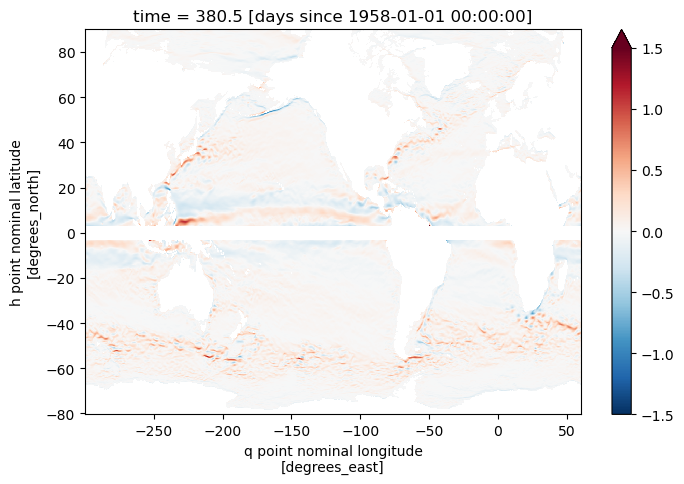

In [18]:
u_s_excl.isel(time=0).where((u_s_excl.yh>3) | (u_s_excl.yh<-3)).plot(cmap='RdBu_r',vmin=-1.5,vmax=1.5)#cmo.balance) #,vmin=-1.5,vmax=1.5,cmap='RdBu_r')

# Calculation of $v_s$ Geostrophic Velocity
<a name="vs_calc"></a>
- we eventually want to get the geostrophic velocity coordinates to match the original vo coordinates (yq,xh). 
- So we need to interpolate the data as follows:
    - Coriolis from (yq,xq) to (yq,xh)
    - ds.zos from (yh,xh) to (yq,xq)
    - dyCv from (yq,xh) to (yq,xq)

In [19]:
Cor_interp2=grid.interp(static.Coriolis,axis="X")
zos_interp2=grid.interp(ds.zos,axis=["X","Y"])
dyCv_interp2=grid.interp(static.dyCv,axis="X")

## Calculate Geostrophic $v_s$ Velocity
<a name="vs"></a>

In [20]:
v_s_excl=(9.8/Cor_interp2) * (grid.diff((zos_interp2),'X',boundary='fill')) / static.dxCv

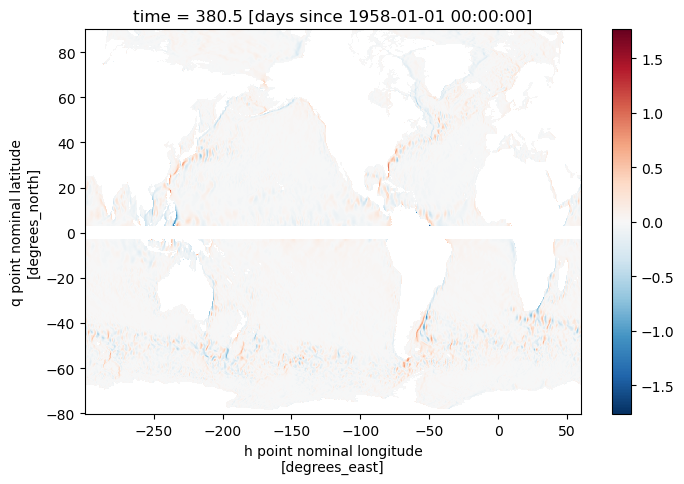

In [21]:
v_s_excl.isel(time=0).where((v_s_excl.yq > 3) | (v_s_excl.yq<-3)).plot()

# Calculation of Geostrophic Shear

- change in geostrophic velocity wrt z (aka vertical gradient)

## Potential density calculation 
- Fucntion for potential density is taken from an equation of state. The paper referenced in the commented out code is ["An Equation of State for use in Ocean Models: Eckart's Formula Revisted"](https://journals.ametsoc.org/view/journals/atot/14/3/1520-0426_1997_014_0735_aeosfu_2_0_co_2.xml) 

In [22]:
def pdens(S,theta):

    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464

    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals

    p = 100000.
    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S

    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))

    return pot_dens

In [23]:
pt=xr.apply_ufunc(pdens,ds1.so,ds1.thetao,
                 dask='parallelized',
                output_dtypes=[ds.pso.dtype])
#print(pt)

In [24]:
#fig=plt.figure(figsize=[15,7])
#pt.isel(z_l=0,time=0).plot(vmin=1020,vmax=1030)

In [25]:
# Plot potential density
'''
fig=plt.figure(figsize=[15,7])
pt.sel(time=15.5,yh=10,method='nearest').plot(vmin=1020,vmax=1030,cmap='RdBu_r')
plt.gca().invert_yaxis()
'''

"\nfig=plt.figure(figsize=[15,7])\npt.sel(time=15.5,yh=10,method='nearest').plot(vmin=1020,vmax=1030,cmap='RdBu_r')\nplt.gca().invert_yaxis()\n"

## Buoyancy Calculation

\begin{equation}
b=-g \frac{\rho \prime}{\rho_0}
\end{equation}

where $g$ is the acceleration due to gravity, $\rho \prime$ is the potential density, and $\rho_0$ is the reference density 


In [26]:
rho_ref = 1035 #1035.
anom_density = pt - rho_ref
#anom_density.isel(time=0,z_l=0).plot()

In [27]:
g = 9.81
buoyancy = -g * anom_density / rho_ref
#buoyancy

## Geostrophic Shear Calculation

We will use the following equations to calculate geostrophic shear:


\begin{align}
    &\frac{\partial u_s}{\partial z} = \frac{\partial \rho^{\prime}}{\partial y} & and& & \frac{\partial v_s}{\partial z} = \frac{\partial \rho^{\prime}}{\partial x}
\end{align}


where $u_s$ and $v_s$ are geostrophic velocity in the $u$ and $v$ directions, and $\rho \prime$ is the anomaly density between the potential density and a reference density of $1035 \, kg/m^2$. 

> - Note: calculating anomaly density (versus just looking at regular density) does not really matter because we are taking the derivative of a constant either way...

Below is a breakdown of the calculation and the corresponding code. Calculation from [Physics Across Oceanography: Fluid Mechanics and Waves](https://uw.pressbooks.pub/ocean285/chapter/geostrophic-shear/)

>- Ultimately, we want the change in velocity with respect to depth aka $\frac{\partial u}{\partial z}$
>- We know that if a flow is in geostrophic balance, then the force from the pressure gradient is equal to the Coriolis force. Let's consider the pressure gradient, which can be calculated w.r.t. $x,y,\,and \,z$. 

\begin{align}
    \frac{\partial P}{\partial x} = \rho_0 f v \qquad \frac{\partial P}{\partial y}=-\rho_0 f u \qquad \frac{\partial P}{\partial z} =-\rho_0 g
\end{align}

>- Since we are focused on change in velocity, we will look at $\frac{\partial P}{\partial y}$ and $\frac{\partial P}{\partial x}$. For brevity's sake, we will only investigate $\frac{\partial P}{\partial y}$, but the same process can be followed for the latter.
>- First, let's rearrange $\frac{\partial P}{\partial y}$ to get an equation for $u$.

\begin{equation}
    u=\frac{\partial P}{\partial y} \times \frac{-1}{f\rho_0}
\end{equation}

>- Take the derivative with respect to z of both sides so we get

\begin{equation}
    \frac{\partial u}{\partial z} = \frac{\partial}{\partial z} \left[\frac{\partial P}{\partial y} \times \frac{1}{\rho_0f}\right]
\end{equation}

>- Rearrange the partial derivatives 

\begin{equation}
     \frac{\partial u}{\partial z} = \frac{\partial}{\partial y} \left[\frac{\partial P}{\partial z} \times \frac{1}{\rho_0f}\right]
\end{equation}

>- Now, we can plug in the pressure gradient in the z direction, $\frac{\partial P}{\partial z}$

\begin{equation}
    \frac{\partial u}{\partial z} = \frac{\partial}{\partial y} \left[-\rho g \times \frac{1}{\rho_0 f} \right]
\end{equation}

>- Rearrange

\begin{equation}
    \frac{\partial u}{\partial z} = \underbrace{-\frac{g}{\rho_0 f}}_{\text{dz_ug=(ddens_dy * g) / (f_V * rho_ref)}} \times \underbrace{\frac{\partial \rho}{\partial y}}_{\text{ddens_dy = grid.diff((anom_density),'Y',boundary='fill)/static.dyCv}}
\end{equation}

### We must interpolate the Coriolis parameter from (yq,xq) to (yh,xh) to match the other variables
<a name="cor"></a>

In [28]:
f_U=grid.interp(static.Coriolis,axis='Y',boundary='fill')
f_V=grid.interp(static.Coriolis,axis='X',boundary='fill')
#Cor_interp3

Compute density gradients in (x,y) direction. We need to first interpolate the static.d_C_ and static.areacello_c_in order to match the coordinates of anom_density. 
- static.dyCu from (yh,xq) to (yh,xh)
- static.dxCv from (yq,xh) to (yh,xh)

In [29]:
dyCu_interp2=grid.interp(static.dyCu,'X',boundary='fill')
dxCv_interp2=grid.interp(static.dxCv,'Y',boundary='fill')

In [30]:
ddens_dx=grid.diff((anom_density),'X',boundary='fill')/static.dxCu
ddens_dy=grid.diff((anom_density),'Y',boundary='fill')/static.dyCv

In [31]:
# why do we do this step for the units
dz_ug =   (ddens_dy * g) / (f_V * rho_ref)
dz_vg = - (ddens_dx * g) / (f_U * rho_ref)

# Plot Geostrophic Shear

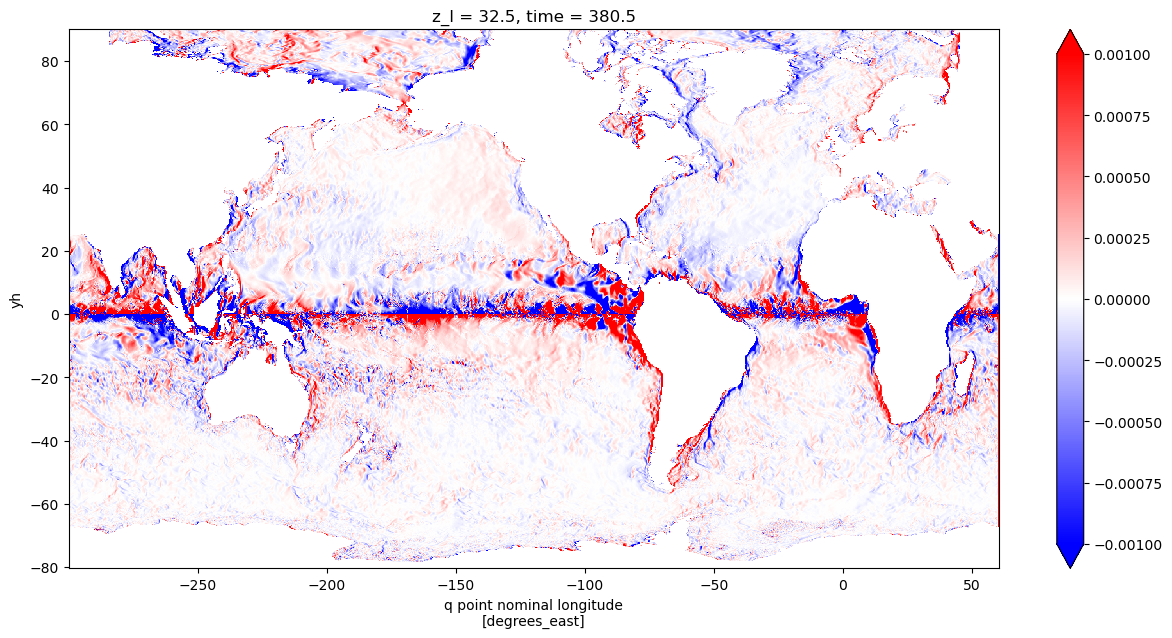

In [32]:
# Geostrophic Shear plot
tmp_v = dz_vg.isel({'z_l': slice(3,4), 'time' : slice(0,1)})

fig = plt.figure(figsize=(15,7))
tmp_v.plot(cmap = 'bwr', vmin = -.001, vmax = 0.001) #cmap=bwr

# Calculation of Geostrophic Velocity for All Depths from Geostrophic Shear
<a name="velofromshear"></a>
- Thus far, we have identified geostrophic velocity and its gradient in the z-direction (geostrophic shear). For simplicity sake, sample explanations will be using $v_g$ and its shear. However, the same concepts covered can be applied to $u_g$. 

- First, let us consider geostrophic shear, which is calculated using the partial derivative of $v$. ** <-- Is $v$ a vector... and the velocity field would be referred to as $V$?..** And $v$ is a function of $(x,y,z)$. So, geostrophic shear is also a function of $(x,y,z)$.

\begin{equation}
    \frac{\partial v_g}{\partial z}
\end{equation}

- Therefore, we can integrate the equation with respect to $z$ to get $v_g$.

- However, we want to integrate from top to bottom, not bottom to top. When we solve for ```indef_int_v```, we must then flip the limits of integration, which requires making the antiderivative negative. 

\begin{equation}
    \int \frac{\partial v_g}{\partial z}dz = -v_g + C \\
\end{equation}

>- Plug in $v(0)$ to the equation

\begin{align}
    \implies &\int \frac{\partial v_g}{\partial z} dz\, \Big|_{z=0} = -v_g(0) + C \\
    C &= v_g(0) + \int \frac{\partial v_g}{\partial z}dz\, \Big|_{z=0} \\
    \int \frac{\partial v}{\partial z} dz &= -v+g + v(0) + \int \frac{\partial v_g}{\partial z}\, \Big|_{z=0}
\end{align}


- where $C$ is a constant. 


- We also know the velocity at the surface of the ocean: $v_s$ where $z=0$. Therefore, we can solve for $C$ by substituting in the surface velocity values. 

\begin{align}
    v_g(x,y,z=0) + C &= v_s \\
    C &= v_s - v_g(x,y,z=0) \\
    \implies v_g &= \int \frac{\partial v_g}{\partial z} dz + v_s - v_g(x,y,z=0) 
\end{align}

- where $v_g(x,y,z=0)$ is the antiderivative of the integrand at z=0. 

## Modification of Coriolis Parameter Data

When we integrate discretely, we will be using a cumsum, we need to make sure that $\forall \frac{\partial v_{g(i,j,k)}}{\partial z} \in \frac{\partial v_g}{dz}, \frac{\partial v_{g(i,j,k)}}{\partial z} \in \mathbb{R}$.
- When we calculated geostrophic shear, we divided by ```f_v```, which is the Coriolis parameter. Since the Coriolis parameter is a function of $sin(\theta)$, at the equator, $sin(0)=0$, the ```f_V```$(0)=0$. This means that geostrophic shear is divided by $0$, which makes the value infinite at the equator. As such, we need to remove those values from the ```dz_vg``` dataset.

## Recalculation of geostrophic shear accounting for this change

In [33]:
f_U2=f_U.where((f_U>0) | (f_U < 0))
f_V2=f_V.where((f_V>0) | (f_V < 0))

In [34]:
# why do we do this step? We need to convert our units back
dz_ug2 =   ddens_dy * g / (f_V2 * rho_ref)
dz_vg2 = - ddens_dx * g / (f_U2 * rho_ref)

## Integration of geostrophic shear

In [35]:
dz=grid.diff(ds1.z_i,axis='Z')
indef_int_v=(dz_vg2* dz).cumsum('z_l',skipna=False)
indef_int_u=(dz_ug2* dz).cumsum('z_l',skipna=False)
#indef_int

## Addition of constant C

In [36]:
#print(v_s_excl.coords)
#print(indef_int_v.coords)
v_s_excl_interp=grid.interp(v_s_excl,axis=['X','Y'],boundary='fill')

#print(u_s_excl.coords)
#print(indef_int_u.coords)
u_s_excl_interp=grid.interp(u_s_excl,axis=['X','Y'],boundary='fill')

/home/jupyter-kuyeda/.conda/envs/tropical_project/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0


In [37]:
velo_from_shear_v= - indef_int_v + v_s_excl_interp - indef_int_v.isel(z_l=0)
#velo_from_shear.max()
velo_from_shear_u= - indef_int_u + u_s_excl_interp - indef_int_u.isel(z_l=0)

# Plan view of components of geostrophic velocity components 

In [38]:
indef_int_v=(dz_vg2* dz).sum('z_l')

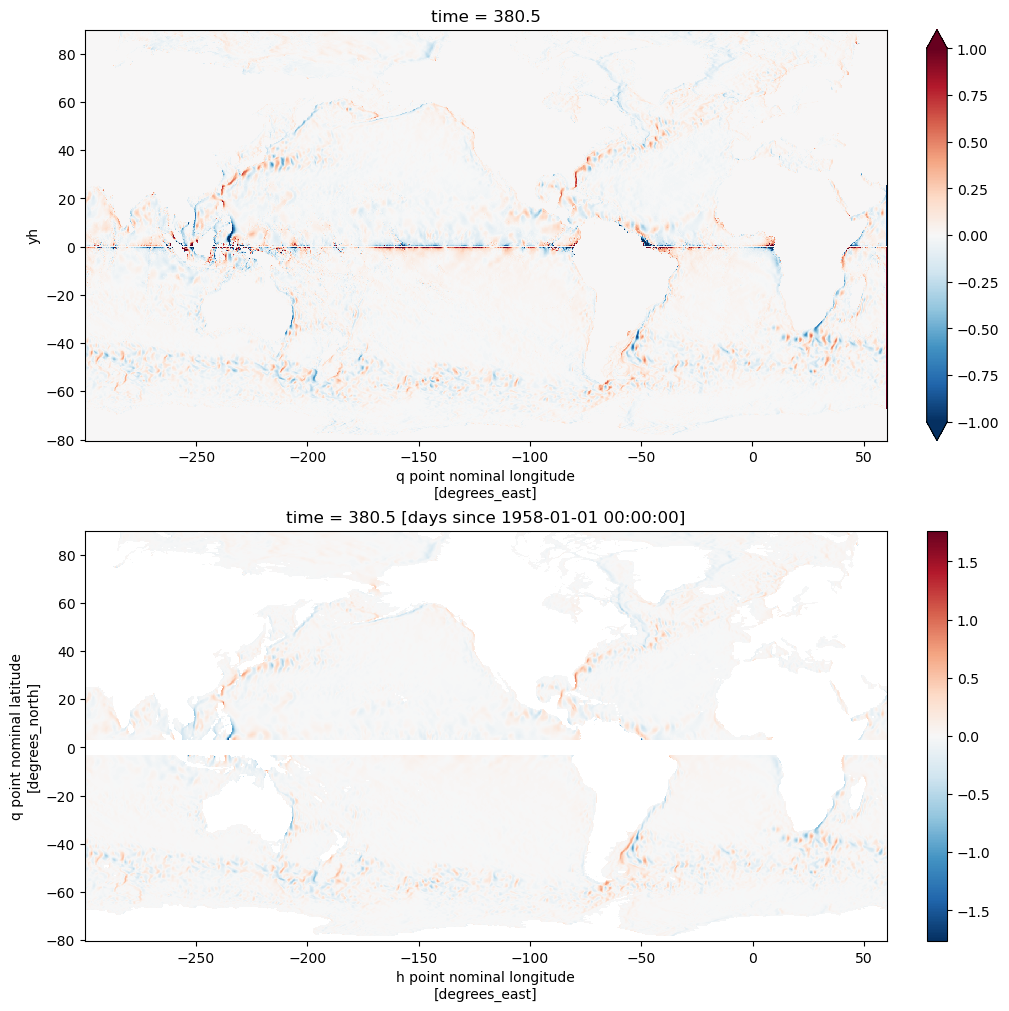

In [61]:
fig,ax=plt.subplots(ncols=1,nrows=2,constrained_layout=True,figsize=(10,10))
indef_int_v.isel(time=0).plot(ax=ax[0],vmin=-1,vmax=1,cmap='RdBu_r')
v_s_excl.isel(time=0).where((v_s_excl.yq > 3) | (v_s_excl.yq<-3)).plot(ax=ax[1])

## Plots of geostrophic $v_g$ velocity calculated from geostrophic shear
<a name="geovveloplot"></a>

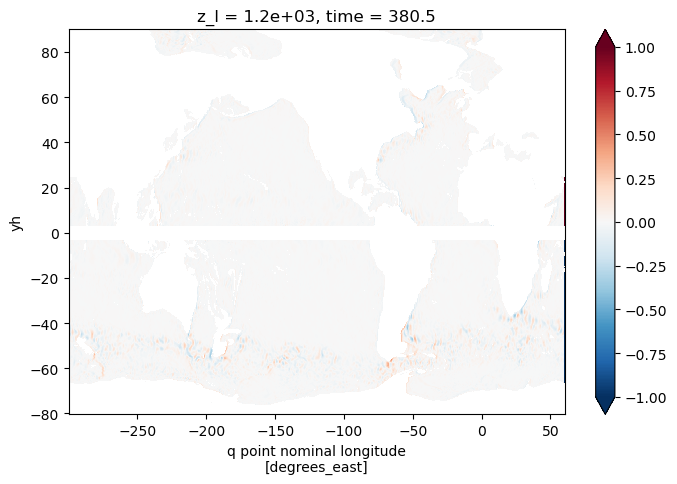

In [40]:
a=velo_from_shear_v.isel(time=0,z_l=20).where((velo_from_shear_v.yh > 3) | (velo_from_shear_v.yh < -3))
a.plot(cmap='RdBu_r',vmin=-1,vmax=1)

### Only looking at the Atlantic basin

(-60.0, 80.0)

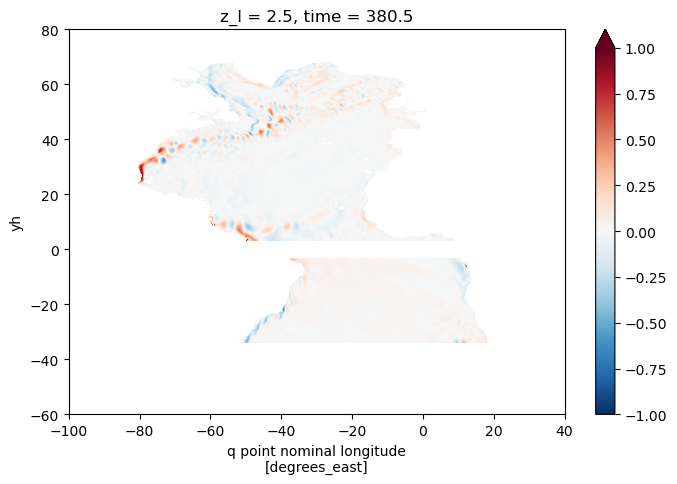

In [41]:
fig,ax=plt.subplots(ncols=1,nrows=1)
b=velo_from_shear_v.isel(time=0,z_l=0).where(basin_interp==2).where((velo_from_shear_v.yh > 3) | (velo_from_shear_v.yh < -3))
b.plot(cmap='RdBu_r',vmin=-1,vmax=1)
ax.set_xlim(-100,40)
ax.set_ylim(-60,80)

### Attempt to recreate [Tuchen et al graphs](https://doi.org/10.1029/2021JC018115)

- depth vs longitude of meridional geostrophic flow at the 11S and 10N. 

In [65]:
#shear
#fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
thing=dz_vg.sel(time=15.5,yh=-11,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
#thing.plot(x='xq',y='z_l',cmap='RdBu_r',vmin=-0.001,vmax=0.001)
#ax.set_xlim(-40,10)
#ax.set_ylim(0,1500)
#plt.gca().invert_yaxis()

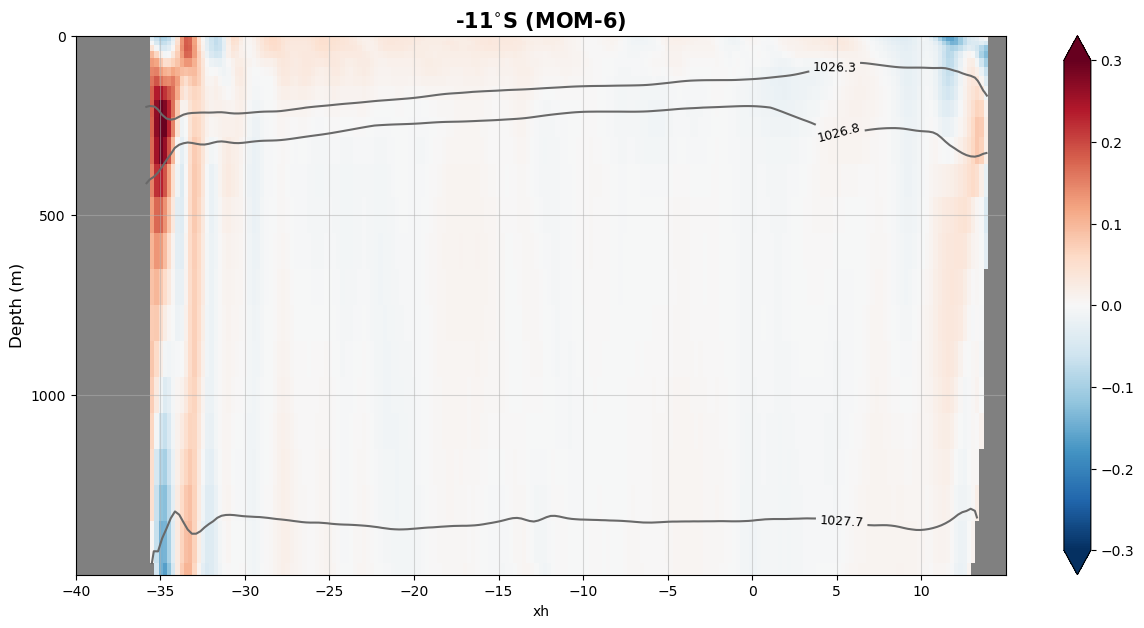

In [43]:
# at 11S
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
thing=velo_from_shear_v.sel(time=15.5,yh=-11,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
thing.plot(x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

rho_levels=pt.sel(time=0,yh=-11,method='nearest').plot.contour(levels=[1026.3,1026.8,1027.7],colors='dimgray')
manual_locations=[(5,100),(5,325),(5,1400)]
cb=ax.clabel(rho_levels,manual=manual_locations,inline_spacing=-18,fontsize=9,colors='k')#,fmt='%1.0f')

ax.set_facecolor('gray')
ax.set_xlim(-40,15)
ax.set_ylabel('Depth (m)',fontsize=12)
ax.set_ylim(0,1500)
ax.set_yticks(np.arange(0,1500,500))
ax.set_xticks(np.arange(-40,15,5))
ax.grid(alpha=0.5)
ax.set_title('-11$^{\circ}$S (MOM-6)',weight='bold',fontsize=15)
plt.gca().invert_yaxis()

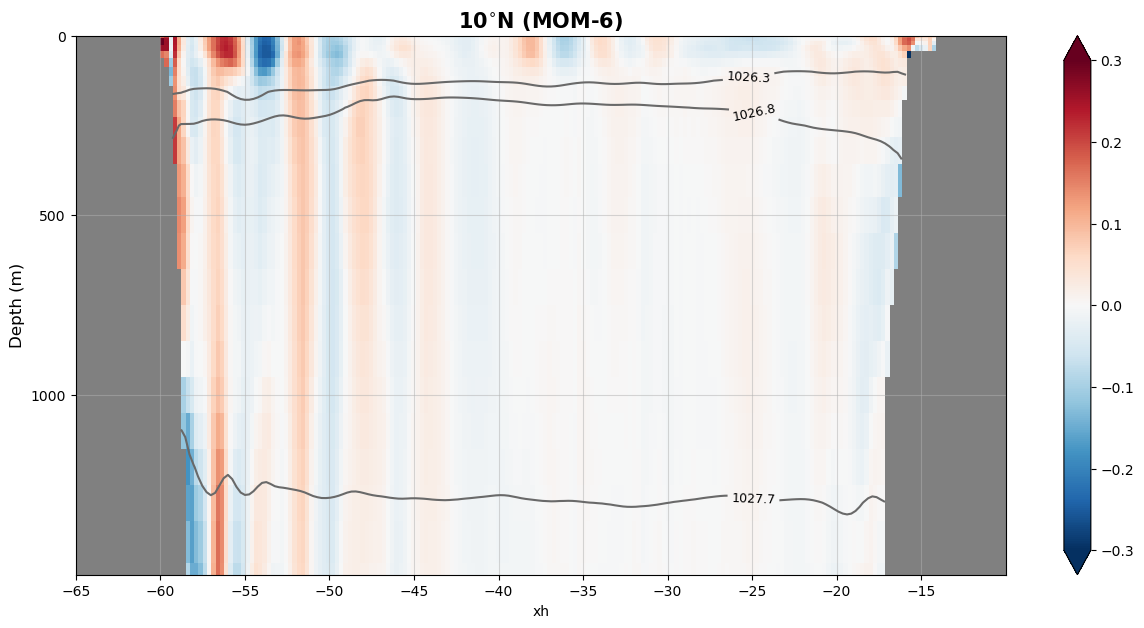

In [44]:
# at 10N
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
thing=velo_from_shear_v.sel(time=15.5,yh=10,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
thing.plot(x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)


rho_levels=pt.sel(time=0,yh=10,method='nearest').plot.contour(levels=[1026.3,1026.8,1027.7],colors='dimgray')
manual_locations=[(-25,150),(-25,250,),(-25,1300)]
cb=ax.clabel(rho_levels,manual=manual_locations,inline_spacing=-18,fontsize=9,colors='k')#,fmt='%1.0f')


ax.set_facecolor('grey')
ax.set_xlim(-65,-10)
ax.set_ylabel('Depth (m)',fontsize=12)
ax.set_ylim(0,1500)
ax.set_title('10$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
ax.set_yticks(np.arange(0,1500,500))
ax.set_xticks(np.arange(-65,-10,5))
ax.grid(alpha=0.5)
plt.gca().invert_yaxis()

In [45]:
# plan view map of vertical velocity of the entire ocean at selected depths
'''
fig,ax=plt.subplots(ncols=1,nrows=2, figsize=(15,15))
north=velo_from_shear_v.sel(time=500,z_l=5000,method='nearest')
north.plot(ax=ax[0],cmap='RdBu_r',vmin=-0.3,vmax=0.3)
south=velo_from_shear_v.sel(time=500,z_l=5,method='nearest')
south.plot(ax=ax[1],cmap='RdBu_r',vmin=-0.3,vmax=0.3)
'''

"\nfig,ax=plt.subplots(ncols=1,nrows=2, figsize=(15,15))\nnorth=velo_from_shear_v.sel(time=500,z_l=5000,method='nearest')\nnorth.plot(ax=ax[0],cmap='RdBu_r',vmin=-0.3,vmax=0.3)\nsouth=velo_from_shear_v.sel(time=500,z_l=5,method='nearest')\nsouth.plot(ax=ax[1],cmap='RdBu_r',vmin=-0.3,vmax=0.3)\n"

Plots for 1959 (12 months) appear to have a lot of positive/negative velocity variation.

In [54]:
#ageostrophic component
uo_interp=grid.interp(ds1.uo,axis=['X','Y'],boundary='extend')
vo_interp=grid.interp(ds1.vo,axis=['X','Y'],boundary='extend')

u_ag=uo_interp-velo_from_shear_u
v_ag=vo_interp-velo_from_shear_v

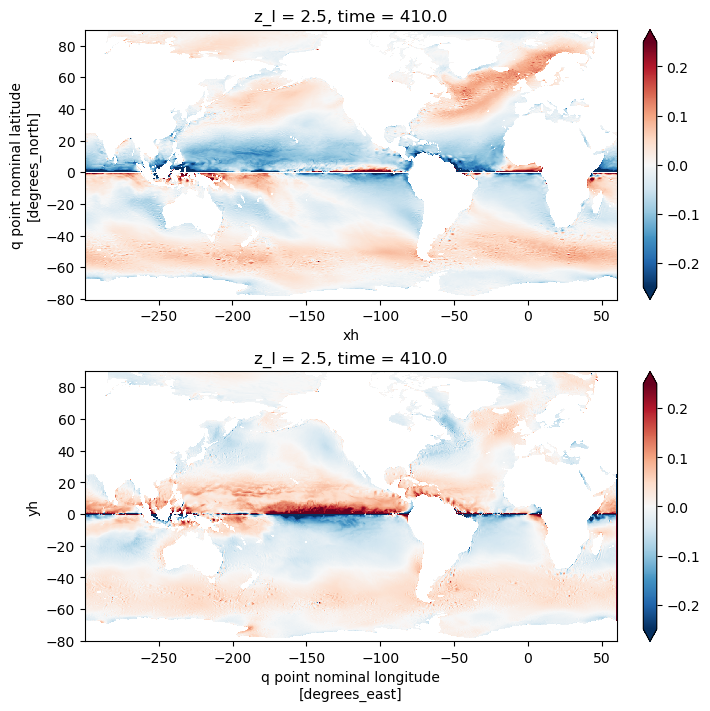

In [64]:
fig,ax=plt.subplots(ncols=1, nrows=2,constrained_layout=True, figsize=(7,7))
u_ag.isel(time=1,z_l=0).plot(ax=ax[0],vmin=-0.25,vmax=0.25,cmap='RdBu_r')
v_ag.isel(time=1,z_l=0).plot(ax=ax[1],vmin=-0.25,vmax=0.25,cmap='RdBu_r')

## Plots of geostrophic $u_g$ velocity calculated from geostrophic shear
<a name="geouvelo"></a>

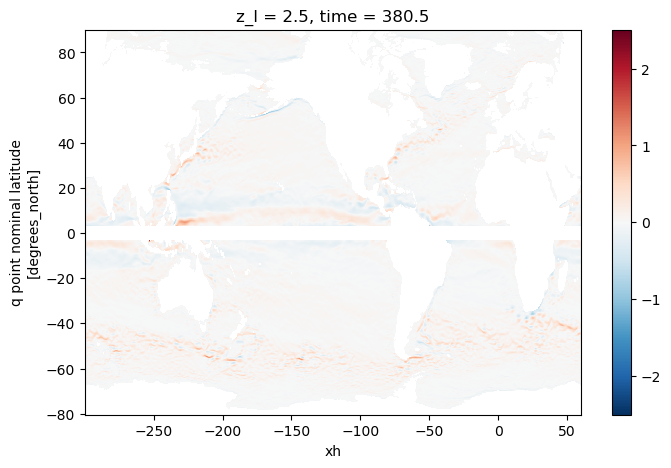

In [56]:
c=velo_from_shear_u.isel(time=0,z_l=0).where((velo_from_shear_u.yq > 3) | (velo_from_shear_u.yq < -3))
c.plot(cmap='RdBu_r')#,vmin=-1,vmax=1)

### Only looking at the Atlantic basin
<a name="uatlbasin"></a>

(-60.0, 80.0)

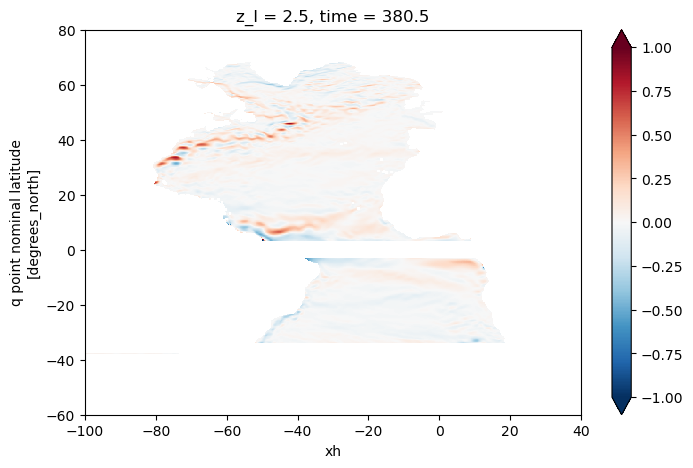

In [57]:
fig,ax=plt.subplots(ncols=1,nrows=1)
d=velo_from_shear_u.isel(time=0,z_l=0).where(basin_interp2==2).where((velo_from_shear_u.yq > 3) | (velo_from_shear_u.yq < -3))
d.plot(cmap='RdBu_r',vmin=-1,vmax=1)
ax.set_xlim(-100,40)
ax.set_ylim(-60,80)